In [1]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

/home/cyy/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading UMAP data
1. loading data from MNIST dataset
2. choosing 600 data points from each training dataset (6000 in total)
3. choosing data points in propotion in the testing sets as well

In [2]:
with open('features_UMAP.npy', 'rb') as f:
    train_x = np.load(f)
    train_y_label = np.load(f)
    test_x = np.load(f)
    test_y = np.load(f)

In [3]:
train_x, train_y_label, test_x, test_y = \
    torch.from_numpy(train_x), torch.from_numpy(train_y_label), \
        torch.from_numpy(test_x), torch.from_numpy(test_y)

### Loading training labels
We use the scores of training samples from DNN to be the y labels

In [4]:
train_y = torch.load('train_score.pt')
train_y.shape

torch.Size([60000, 10])

## Setting up the Model

In [5]:
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [6]:
n = 2000
train_x, train_y = train_x[0: n], train_y[0: n, :]
test_y = test_y.to(torch.int64)
train_y.shape

torch.Size([2000, 10])

if we are training log(y) = x, runing the cell below once

In [7]:
add = - torch.min(train_y) + 1
log_y = add + train_y
log_y = torch.log(log_y)
log_y

tensor([[3.5338, 3.4919, 3.2481,  ..., 3.3969, 3.6682, 3.6651],
        [3.8828, 3.1038, 3.4243,  ..., 3.3806, 3.4736, 3.4864],
        [3.6790, 3.6857, 3.7596,  ..., 3.7208, 3.6818, 3.7443],
        ...,
        [3.3748, 3.2066, 2.7815,  ..., 2.8672, 3.6335, 3.4734],
        [3.6176, 3.6790, 3.8828,  ..., 3.7065, 3.6771, 3.4933],
        [3.8812, 3.7062, 3.7518,  ..., 3.6865, 3.8139, 3.7675]])

### Model Structure

In [8]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(RBFKernel())
        self.covar_module = gpytorch.kernels.MaternKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Doing Cross Validation on Training data

Initialize the model and parameters

In [9]:
all_index = np.arange(0, n)
models, likelihoods, mlls, opts = [], [], [], []
lr = 0.1

for j in range(10):
    mo, l, ml, o = [], [], [], []
    for k in range(10):
        val_index = np.arange(np.floor(n/10)*k, np.floor(n/10)*(k+1))
        train_index = [i for i in all_index if i not in val_index]
        x = train_x[train_index, :]
        y = log_y[train_index, j]
        
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(x, y, likelihood)
        likelihood.train()
        model.train()
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        
        l.append(likelihood)
        mo.append(model)
        ml.append(mll)
        
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)  # Includes GaussianLikelihood parameters
        o.append(optimizer)
        
    models.append(mo)
    likelihoods.append(l)
    mlls.append(ml)
    opts.append(o)
    
# models[0][1] represents label 0 and the first fold

In [ ]:
training_iter = 10
# train_y = torch.load('train_score.pt') : x axis
pred_train_y = []


for j in range(10):  # j represents the 10 labels
    p = []
    for k in range(10): # k represents the k fold cross validation
        print("Model", j, ", Cross Validation Group", k)
        # initialize the model
        val_index = np.arange(np.floor(n/10)*k, np.floor(n/10)*(k+1))
        train_index = [i for i in all_index if i not in val_index]
        tr_x = train_x[train_index, :]
        val_x = train_x[val_index, :]
        tr_y = log_y[train_index, j]
        # val_y = train_y[val_index, k]
        likelihood = likelihoods[j][k]
        model = models[j][k]
        mll = mlls[j][k]
        optimizer = opts[j][k]
        
        # training
        for i in range(training_iter):                
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(tr_x)
            # print(output.shape, tr_y.shape)
            
            # Calc loss and backprop gradients
            loss = -mll(output, tr_y)
            loss.backward()
            
            if i % 4 == 0:
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, training_iter, loss.item(),
                    #model.covar_module.base_kernel.lengthscale.item(),
                    0.1,
                    model.likelihood.noise.item()
                ))
            optimizer.step()
        
            # evaluation of the current model
        model.eval()
        likelihood.eval()
        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            test_dist = model(val_x)
            pred_means = test_dist.loc
            p.append(pred_means)
    p = torch.stack(p)
    pred_train_y.append(p)        
    
    

In [12]:
len(pred_train_y) # 100
pred_train_y[0].shape #200
# train_y.shape # 2000 * 10

torch.Size([10, 200])

In [13]:
for j in range(10):
    pred_train_y[j] = pred_train_y[j].view(1, -1).flatten()
    pred_train_y[j] = torch.exp(pred_train_y[j]) - add

In [14]:
train_y[0:14, 0]

tensor([-1.4306e+01, -4.7684e-07, -8.9569e+00, -1.6103e+01, -1.5714e+01,
        -1.5772e+01, -2.1715e+01, -2.6282e+01, -1.9224e+01, -1.5905e+01,
        -2.8469e+01, -1.7973e+01, -2.7900e+01, -1.3567e+01])

In [15]:
pred_train_y[0][0:14]

tensor([-19.6471,   1.3205, -10.6702, -14.2392, -12.8237, -14.5740, -18.9731,
        -21.0948, -18.8056, -13.8968, -26.7614, -18.5707, -22.1842, -13.8132])

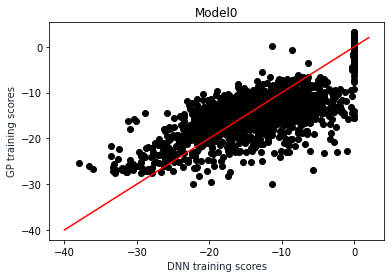

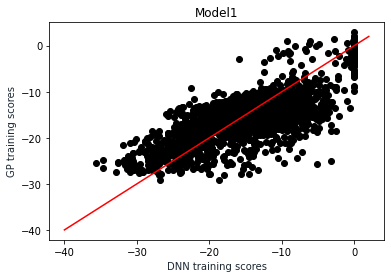

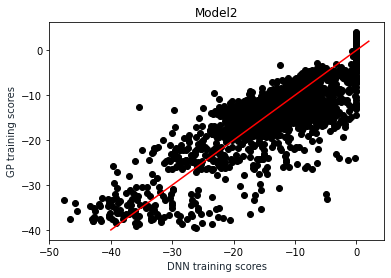

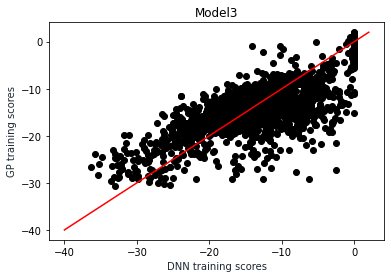

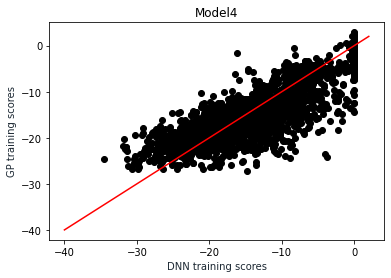

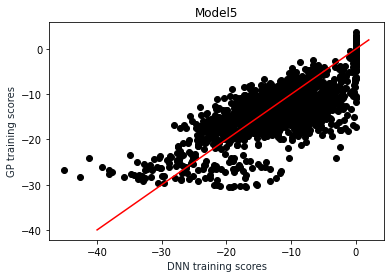

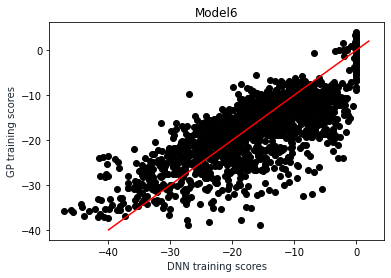

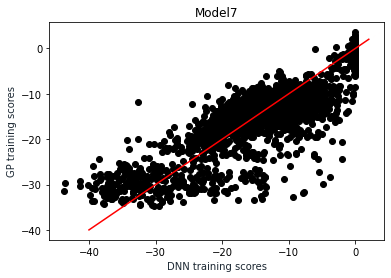

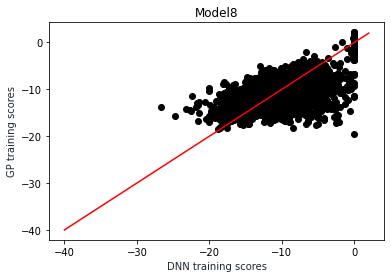

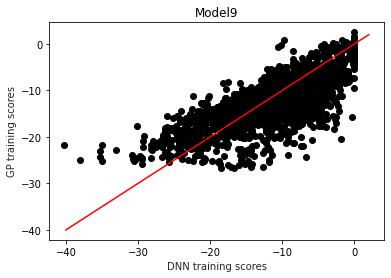

<Figure size 432x288 with 0 Axes>

In [16]:
for j in range(10):
    name = "model" + str(j) +".png"
    x_data = train_y[:, j]
    y_data= pred_train_y[j]
    plt.plot(x_data, y_data, 'o', color='black')
    x = np.linspace(-40,2,100)
    y = x
    plt.plot(x, y, '-r', label='y=2x+1')
    plt.title('Model' + str(j))
    plt.xlabel('DNN training scores', color='#1C2833')
    plt.ylabel('GP training scores', color='#1C2833')
    plt.savefig(name)
    plt.show()